# COGS 108 - Data Checkpoint

# Names

- Dina Dehaini
- Cody Maheu
- Ryan Jackson
- Lauren Taylor
- Andrew Karafilis Tremaine

<a id='research_question'></a>
# Research Question

Can the wealth of a country determine whether their agricultural exports will be used as food (finalized goods for humans) or feed (raw product for consumption by animals to produce other goods)?

# Dataset(s)

**Dataset Name:** GDP (Current US$) **(GDP)**
 - **Link to Dataset:** https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?end=2019&name_desc=false&start=1960
 - **Number of observations:** 265
 - **Description:** World Bank national accounts data, and OECD National Accounts data files of countries’ GDP.
     - **Timeline:** 1960-2019
     - Data are in current U.S. dollars

**Dataset Name:** Who eats the food we grow? **(FAO)**
 - **Link to Dataset:** https://www.kaggle.com/dorbicycle/world-foodfeed-production
 - **Number of observations:** 21,477
 - **Description:** “The Food and Agriculture Organization of the United Nations provides free access to food and agriculture data for over 245 countries and territories.” (https://www.kaggle.com/dorbicycle/world-foodfeed-production)  The dataset that we are interested in is the Food Balance Sheets. It has the data of a country's food supply during a specified reference period  specifically in our case food/feed.  
     - **Timeline:** 1961-2013
     - Food - refers to the quantity of the food item available as human food during the reference period.
     - Feed - refers to the quantity of the food item available for feeding to the livestock and poultry during the reference period.

**Combining Data**
 - The data will be merged together based on their country code (Area abbreviation in FAO, Country code in GDP). We will examine the data that cannot be merged by hand.



# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

# GDP dataset
gdp = pd.read_csv("GDP.csv")

# GDP per capita dataset
gdp_per_capita = pd.read_csv("GDP_PER_CAPITA.csv")

# Feed vs Food dataset (it's encoded in CP1252...)
fao = pd.read_csv("FAO.csv", encoding="latin1")

# All valid ISO-3166 country codes (for cleaning the GDP dataset)
with open("country_codes.txt", "r") as fh:
    country_codes = set(line[:-1] for line in fh)

# Data Cleaning

Describe your data cleaning steps here.

- The dataset has been read in from CSV files into our Dataframe objects for both FAO and GDP.
- We removed rows from the GDP dataset with invalid country codes.

- We have begun the steps to begin to understand the data and figure out where our data outliers are coming from. (USA skews it heavily.)
- The FAO dataset has no NaN values but GDP has NaN values for years where a given country did not exist (and some years past 2013 for unknown reasons). We will need to factor this in when merging the datasets.


In [2]:
# Dumping the columns for reference
gdp.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', 'Unnamed: 65'],
      dtype='object')

In [3]:
# Dumping the columns for reference
gdp_per_capita.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', 'Unnamed: 65'],
      dtype='object')

In [4]:
# Dumping the columns for reference
fao.columns

Index(['Area Abbreviation', 'Area Code', 'Area', 'Item Code', 'Item',
       'Element Code', 'Element', 'Unit', 'latitude', 'longitude', 'Y1961',
       'Y1962', 'Y1963', 'Y1964', 'Y1965', 'Y1966', 'Y1967', 'Y1968', 'Y1969',
       'Y1970', 'Y1971', 'Y1972', 'Y1973', 'Y1974', 'Y1975', 'Y1976', 'Y1977',
       'Y1978', 'Y1979', 'Y1980', 'Y1981', 'Y1982', 'Y1983', 'Y1984', 'Y1985',
       'Y1986', 'Y1987', 'Y1988', 'Y1989', 'Y1990', 'Y1991', 'Y1992', 'Y1993',
       'Y1994', 'Y1995', 'Y1996', 'Y1997', 'Y1998', 'Y1999', 'Y2000', 'Y2001',
       'Y2002', 'Y2003', 'Y2004', 'Y2005', 'Y2006', 'Y2007', 'Y2008', 'Y2009',
       'Y2010', 'Y2011', 'Y2012', 'Y2013'],
      dtype='object')

In [5]:
# Remove any countries from the GDP dataset that aren't in the FAO dataset.
# Also ensure they're all valid country codes -- there are several
# "total" rows that sum together multiple countries in the GDP dataset.
fao_countries = set(fao["Area Abbreviation"])
valid_countries = fao_countries & country_codes
gdp = gdp[[country in valid_countries for country in gdp["Country Code"]]]

# Year, Country Code, Tons of Food, Tons of Feed, Real GDP, Real GDP Per Capita
data = pd.DataFrame(columns=["year", "country", "food", "feed", "gdp", "gdp_per_capita"])

#for reasons regarding the start and end date, see the EDA section with the plot of countries with feed/food
#    data over time.
START = 1992
END = 2013

for year in range(START, END + 1):
    # Convert from thousands of tons to tons
    food_totals = fao[fao["Element"] == "Food"].groupby(["Area Abbreviation"])["Y%d" % year].sum() * 1000
    feed_totals = fao[fao["Element"] == "Feed"].groupby(["Area Abbreviation"])["Y%d" % year].sum() * 1000

    for _, country in gdp.iterrows():
        gdp_for_year = country[str(year)]
        food_for_year = food_totals[country["Country Code"]]
        per_capita_for_year, = gdp_per_capita[gdp_per_capita["Country Code"] == country["Country Code"]][str(year)]

        # Throw out unless we have both GDP data and food export data for the year
        # (feed export data can be 0)
        if not np.isnan(gdp_for_year) and food_for_year > 0:
            data = data.append({
                "year": year,
                "country": country["Country Code"],
                "food": food_for_year,
                "feed": feed_totals[country["Country Code"]],
                "gdp": gdp_for_year,
                "gdp_per_capita": per_capita_for_year
            }, ignore_index=True)

In [6]:
# Dictionary to convert from country codes to full name
country_names = dict(zip(gdp["Country Code"], gdp["Country Name"]))

# Data Analysis & Results (EDA)

In [7]:
latest = data[data["year"] == 2013]

In [8]:
# Show the top and bottom 10 countries by GDP in 2013.
out = latest.sort_values("gdp", ascending=False)
out["country"] = out["country"].apply(lambda x: country_names[x])

In [9]:
out.head(n=10)

,year,country,food,feed,gdp,gdp_per_capita
3530,2013,United States,6.417760e+08,296863000.0,1.678485e+13,53117.667850
3402,2013,China,2.541768e+09,702607000.0,9.570406e+12,7050.646271
3451,2013,Japan,1.531610e+08,34952000.0,5.155717e+12,40454.447458
3412,2013,Germany,1.584730e+08,60418000.0,3.732743e+12,46285.764069
3425,2013,France,1.205420e+08,45537000.0,2.811078e+12,42592.934094
3427,2013,United Kingdom,1.229460e+08,27033000.0,2.786023e+12,43444.533002
3394,2013,Brazil,3.124880e+08,127479000.0,2.472807e+12,12300.324882
3502,2013,Russian Federation,2.538920e+08,117021000.0,2.292473e+12,15974.644627
3448,2013,Italy,1.211630e+08,32287000.0,2.141315e+12,35549.974697
3442,2013,India,1.238335e+09,98258000.0,1.856722e+12,1449.605912


In [10]:
out.tail(n=10)

,year,country,food,feed,gdp,gdp_per_capita
3380,2013,Antigua and Barbuda,119000.0,0.0,1.181448e+09,12909.744178
3432,2013,Guinea-Bissau,1220000.0,10000.0,1.046087e+09,634.662809
3434,2013,Grenada,122000.0,28000.0,8.426201e+08,7789.776381
3457,2013,St. Kitts and Nevis,56000.0,0.0,8.397741e+08,16686.021183
3535,2013,Vanuatu,370000.0,12000.0,8.017876e+08,3124.233078
3536,2013,Samoa,329000.0,8000.0,7.700217e+08,4037.509315
3532,2013,St. Vincent and the Grenadines,158000.0,63000.0,7.212074e+08,6639.607146
3414,2013,Dominica,138000.0,41000.0,4.982963e+08,7016.676471
3511,2013,Sao Tome and Principe,251000.0,0.0,3.005538e+08,1564.675304
3456,2013,Kiribati,135000.0,0.0,1.851139e+08,1715.765331


In [11]:
# Show the top and bottom 10 countries by food export in 2013.
out = latest.sort_values("food", ascending=False)
out["country"] = out["country"].apply(lambda x: country_names[x])

In [12]:
out.head(n=10)

,year,country,food,feed,gdp,gdp_per_capita
3402,2013,China,2.541768e+09,702607000.0,9.570406e+12,7050.646271
3442,2013,India,1.238335e+09,98258000.0,1.856722e+12,1449.605912
3530,2013,United States,6.417760e+08,296863000.0,1.678485e+13,53117.667850
3394,2013,Brazil,3.124880e+08,127479000.0,2.472807e+12,12300.324882
3502,2013,Russian Federation,2.538920e+08,117021000.0,2.292473e+12,15974.644627
3441,2013,Indonesia,2.378260e+08,19062000.0,9.125241e+11,3623.911582
3486,2013,Nigeria,2.288770e+08,72046000.0,5.086930e+11,2961.550284
3493,2013,Pakistan,1.809940e+08,9511000.0,2.312186e+11,1208.904310
3473,2013,Mexico,1.665910e+08,43530000.0,1.274443e+12,10725.183317
3412,2013,Germany,1.584730e+08,60418000.0,3.732743e+12,46285.764069


In [13]:
out.tail(n=10)

,year,country,food,feed,gdp,gdp_per_capita
3536,2013,Samoa,329000.0,8000.0,7.700217e+08,4037.509315
3511,2013,Sao Tome and Principe,251000.0,0.0,3.005538e+08,1564.675304
3463,2013,St. Lucia,216000.0,13000.0,1.664817e+09,9378.562363
3532,2013,St. Vincent and the Grenadines,158000.0,63000.0,7.212074e+08,6639.607146
3414,2013,Dominica,138000.0,41000.0,4.982963e+08,7016.676471
3456,2013,Kiribati,135000.0,0.0,1.851139e+08,1715.765331
3434,2013,Grenada,122000.0,28000.0,8.426201e+08,7789.776381
3380,2013,Antigua and Barbuda,119000.0,0.0,1.181448e+09,12909.744178
3392,2013,Bermuda,103000.0,3000.0,6.465756e+09,99471.638898
3457,2013,St. Kitts and Nevis,56000.0,0.0,8.397741e+08,16686.021183


In [14]:
# Show the top and bottom 10 countries by feed export in 2013.
out = latest.sort_values("feed", ascending=False)
out["country"] = out["country"].apply(lambda x: country_names[x])

In [15]:
out.head(n=10)

,year,country,food,feed,gdp,gdp_per_capita
3402,2013,China,2.541768e+09,702607000.0,9.570406e+12,7050.646271
3530,2013,United States,6.417760e+08,296863000.0,1.678485e+13,53117.667850
3394,2013,Brazil,3.124880e+08,127479000.0,2.472807e+12,12300.324882
3502,2013,Russian Federation,2.538920e+08,117021000.0,2.292473e+12,15974.644627
3442,2013,India,1.238335e+09,98258000.0,1.856722e+12,1449.605912
3528,2013,Ukraine,7.958000e+07,74170000.0,1.833101e+11,4029.711252
3486,2013,Nigeria,2.288770e+08,72046000.0,5.086930e+11,2961.550284
3412,2013,Germany,1.584730e+08,60418000.0,3.732743e+12,46285.764069
3420,2013,Spain,8.105100e+07,56543000.0,1.354757e+12,29059.547952
3399,2013,Canada,6.789300e+07,52274000.0,1.847209e+12,52652.593683


In [16]:
out.tail(n=10)

,year,country,food,feed,gdp,gdp_per_capita
3465,2013,Lesotho,1801000.0,2000.0,2.421470e+09,1193.713255
3398,2013,Central African Republic,4185000.0,2000.0,1.691544e+09,380.298168
3456,2013,Kiribati,135000.0,0.0,1.851139e+08,1715.765331
3511,2013,Sao Tome and Principe,251000.0,0.0,3.005538e+08,1564.675304
3380,2013,Antigua and Barbuda,119000.0,0.0,1.181448e+09,12909.744178
3472,2013,Maldives,559000.0,0.0,3.295011e+09,7928.457365
3507,2013,Solomon Islands,727000.0,0.0,1.284699e+09,2248.591321
3503,2013,Rwanda,18547000.0,0.0,7.819538e+09,723.258313
3413,2013,Djibouti,791000.0,0.0,2.042817e+09,2312.728803
3457,2013,St. Kitts and Nevis,56000.0,0.0,8.397741e+08,16686.021183


<AxesSubplot:xlabel='gdp', ylabel='Density'>

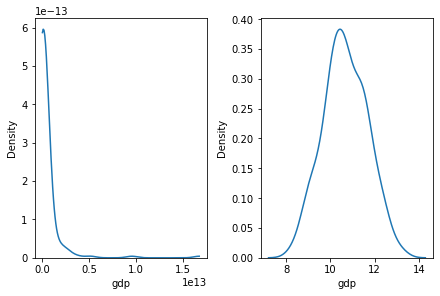

In [17]:
# Normal and log-scale plots of the distribution of GDP
# Average is a "10 figure" GDP from reading the log plot
fig, (normal, log) = plt.subplots(1, 2, constrained_layout=True)

sns.kdeplot(latest["gdp"], cut=0, ax=normal)
sns.kdeplot(np.log10(latest["gdp"]), ax=log)

<AxesSubplot:xlabel='gdp_per_capita', ylabel='Density'>

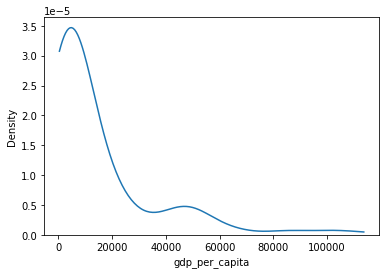

In [18]:
sns.kdeplot(latest["gdp_per_capita"],cut=0)

<AxesSubplot:xlabel='food', ylabel='Density'>

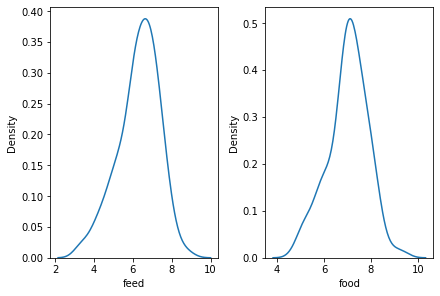

In [19]:
# Log-scale plots of the distribution of total feed exported and total food exported in 2013
# Measured in tons
fig, (normal, log) = plt.subplots(1, 2, constrained_layout=True)

sns.kdeplot(np.log10(latest[latest["feed"] > 0]["feed"]), ax=normal)
sns.kdeplot(np.log10(latest["food"]), ax=log)

In [20]:
# All countries that exported no feed in 2013
out = latest[latest["feed"] <= 0][:]
out["country"] = out["country"].apply(lambda x: country_names[x])

out

,year,country,food,feed,gdp,gdp_per_capita
3380,2013,Antigua and Barbuda,119000.0,0.0,1.181448e+09,12909.744178
3413,2013,Djibouti,791000.0,0.0,2.042817e+09,2312.728803
3456,2013,Kiribati,135000.0,0.0,1.851139e+08,1715.765331
3457,2013,St. Kitts and Nevis,56000.0,0.0,8.397741e+08,16686.021183
3472,2013,Maldives,559000.0,0.0,3.295011e+09,7928.457365
3503,2013,Rwanda,18547000.0,0.0,7.819538e+09,723.258313
3507,2013,Solomon Islands,727000.0,0.0,1.284699e+09,2248.591321
3511,2013,Sao Tome and Principe,251000.0,0.0,3.005538e+08,1564.675304


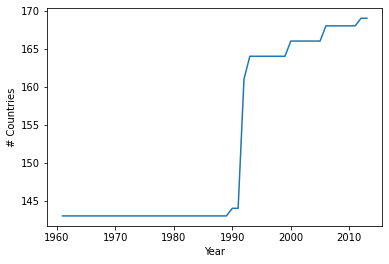

In [21]:
# Number of countries with data present over time
food = fao[fao["Element"] == "Food"].groupby(["Area Abbreviation"]).sum()
years = [np.count_nonzero(food["Y%d" % i]) for i in range(1961, END + 1)]

sns.lineplot(x=range(1961, END+1), y=years)
plt.xlabel("Year")
_ = plt.ylabel("# Countries")

After the fall of the Soviet Union, many more countries began to share their Feed/Food data. Rather than use the data from before this data and extrapolate the values, we chose to only consider data from 1992-2013. Additional country data was added after 1992 and these countries are removed from the set. 

NormaltestResult(statistic=8.66624439353652, pvalue=0.01312649992848708)


<AxesSubplot:ylabel='Density'>

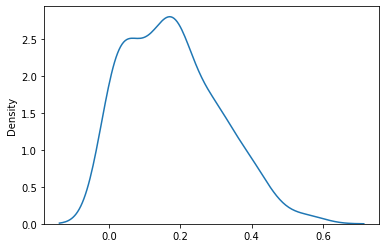

In [22]:
percents = latest["feed"] / (latest["food"] + latest["feed"])

print(stats.normaltest(percents))
sns.kdeplot(percents)

<AxesSubplot:xlabel='year', ylabel='food'>

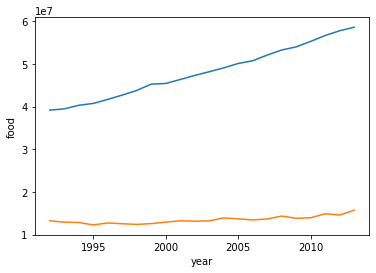

In [23]:
g = data.groupby("year")
sns.lineplot(data=g["food"].agg("mean"))
sns.lineplot(data=g["feed"].agg("mean"))

In [31]:
mean_gdp = data.groupby("year")["gdp"].agg("mean")
mean_gdp_per_capita = data.groupby("year")["gdp_per_capita"].agg("mean")
mean_ratio = [(year["feed"] / (year["food"] + year["feed"])).agg("mean") for _, year in data.groupby("year")]

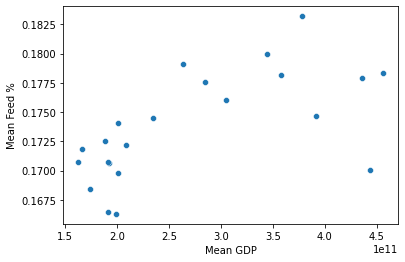

In [30]:
sns.scatterplot(x=mean_gdp, y=mean_ratio)
plt.xlabel("Mean GDP")
_ = plt.ylabel("Mean Feed %")

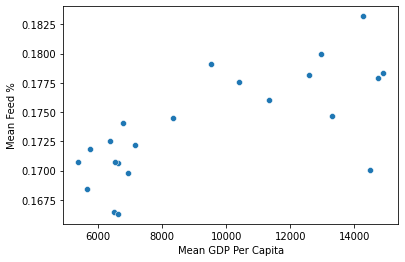

In [32]:
sns.scatterplot(x=mean_gdp_per_capita, y=mean_ratio)
plt.xlabel("Mean GDP Per Capita")
_ = plt.ylabel("Mean Feed %")

After looking at the negative correlation of the data, we can start to see that our initial hypothesis might not be correct. Countries with large GDP's tend to have a lower percentage of feed as an export.

R: 0.626845, P-value: 0.001797, Err: 0.000000


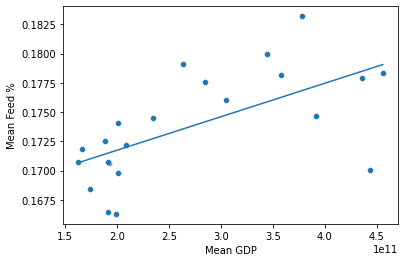

In [36]:
slope, intercept, *test_stats = stats.linregress(mean_gdp, mean_ratio)
lim = np.array([min(mean_gdp), max(mean_gdp)])

sns.scatterplot(x=mean_gdp, y=mean_ratio)
sns.lineplot(x=lim, y=slope * lim + intercept)
plt.xlabel("Mean GDP")
plt.ylabel("Mean Feed %")

print("R: %f, P-value: %f, Err: %f" % tuple(test_stats))

R: 0.707402, P-value: 0.000231, Err: 0.000000


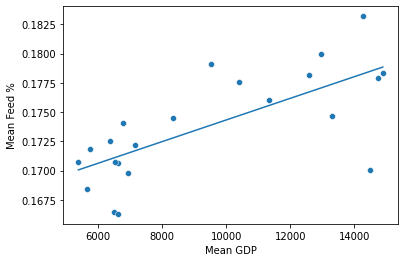

In [37]:
slope, intercept, *test_stats = stats.linregress(mean_gdp_per_capita, mean_ratio)
lim = np.array([min(mean_gdp_per_capita), max(mean_gdp_per_capita)])

sns.scatterplot(x=mean_gdp_per_capita, y=mean_ratio)
sns.lineplot(x=lim, y=slope * lim + intercept)
plt.xlabel("Mean GDP Per Capita")
plt.ylabel("Mean Feed %")

print("R: %f, P-value: %f, Err: %f" % tuple(test_stats))

<AxesSubplot:>

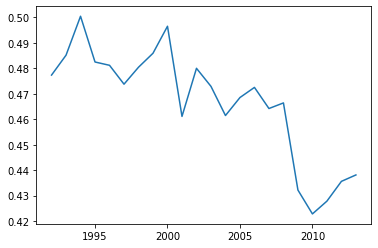

In [44]:
rvalues = []

for year in range(START, END + 1):
    year = data[data["year"] == year]
    rvalue = stats.linregress(np.log10(year["gdp"]), year["feed"] / (year["feed"] + year["food"])).rvalue
    rvalues.append(rvalue)

sns.lineplot(x=range(START, END + 1), y=rvalues)

# Project Proposal (updated)

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 2/11  | 4 PM  | Checkpoint 1 Review | Wrangle data |
| 2/14  | 2 PM  | EDA stuff | start checkpoint 2 |
| 2/17  | 4 PM  | prep checkpoint 2 turnin | turn checkpoint 2 in |
| 2/21  | 2 PM  | talk about data analysis | data analysis |
| 2/24  | 4 PM  | more data analysis, clean up notebook | review notebook |
